In [14]:
using Plots, Random, OnlineStats, CSV
using Distributed, IterTools, SharedArrays
import StatsBase: zscore

In [4]:
function make_regression(;npoints=100, noise=10, rng=Random.GLOBAL_RNG)
    xs = rand(rng, npoints) * 100
    steep = rand(rng) * 8 - 4
    intercept = rand(rng) * 100 - 50
    ys = map(x->steep*x + intercept + rand(rng)*noise, xs)
    return (xs, ys)
end

make_regression (generic function with 1 method)

## Least Squares Method

[25.5232, 1.1313]


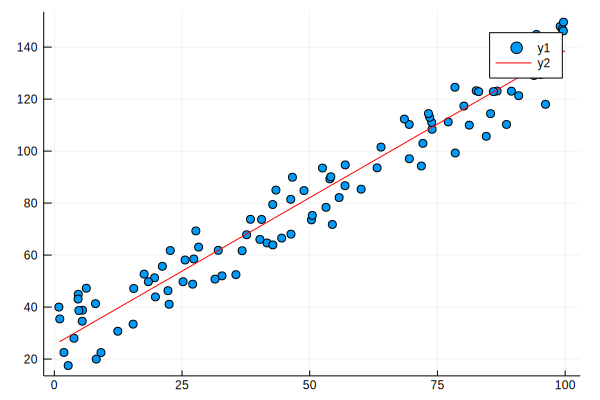

In [6]:
let
    x, y = make_regression(npoints=100, noise=30, rng=MersenneTwister(1134))

    o = fit!(LinReg(), ([ones(size(x,1)) x],y))
    coefs = coef(o)
    println(coefs)

    scatter(x, y)
    plot!(1:100, map(x->x*coefs[2] + coefs[1], 1:100), color=:red)
end

## Partitioned Least Squares

[25.5232, 1.1313]


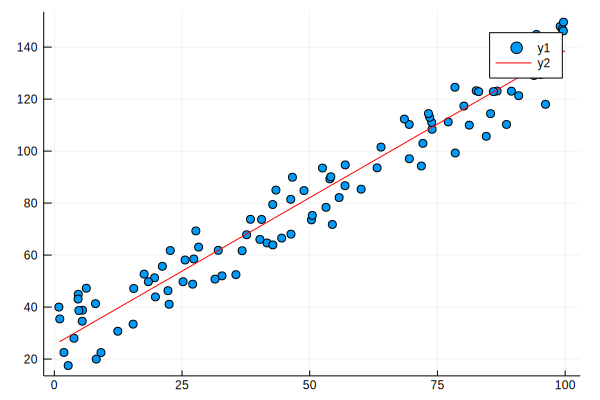

In [7]:
let
    x, y = make_regression(npoints=100, noise=30, rng=MersenneTwister(1134))

    lr = LinReg()
    p = Partition(lr, 10)
    xs = [ones(size(x,1)) x]
    fit!(p, (xs, y))
    o = reduce(merge, p.parts).stat
    coefs = coef(o)
    println(coefs)

    scatter(x, y)
    plot!(1:100, map(x->x*coefs[2] + coefs[1], 1:100), color=:red)
end

## Distributed Least Squares

In [34]:
rmprocs(workers())

┌ Warning: rmprocs: process 1 not removed
└ @ Distributed /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v1.0/Distributed/src/cluster.jl:932


Task (done) @0x000000011462aad0

[25.5232, 1.1313]


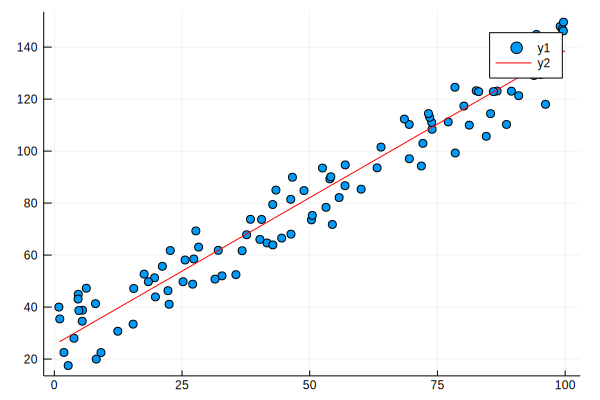

In [12]:
let
    addprocs(3)
    @everywhere using OnlineStats

    x, y = make_regression(npoints=100, noise=30, rng=MersenneTwister(1134))

    xs = [ones(size(x,1)) x]

    #o = @distributed merge for i in 1:size(xs,1)
    #    OnlineStats.fit!(LinReg(), (xs[i,:], y[i]))
    #end

    o = reduce(merge, pmap(p->OnlineStats.fit!(LinReg(), (xs[[p...],:], y[[p...]])), partition(1:size(xs,1), 10)))
    #o = reduce(merge, pmap(i->OnlineStats.fit!(LinReg(), (xs[i,:], y[i])), 1:size(xs,1), batch_size=10))

    rmprocs(workers())

    coefs = coef(o)
    println(coefs)

    scatter(x, y)
    plot!(1:100, map(x->x*coefs[2] + coefs[1], 1:100), color=:red)
end

## Stochastic Gradient Descent

[83.6099, 35.3645]


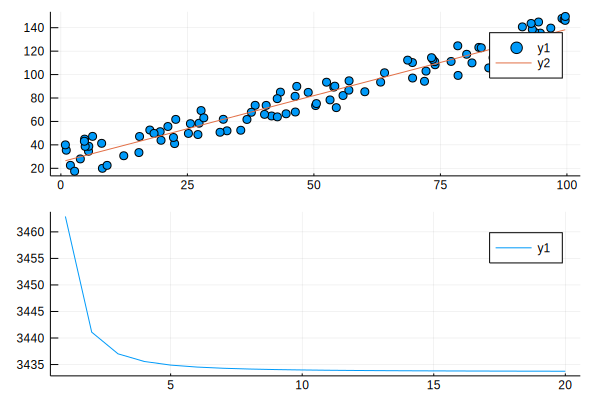

In [13]:
let
    x, y = make_regression(npoints=100, noise=30, rng=MersenneTwister(1134))

    m = fit!(Moments(), x)
    μ, σ = mean(m), std(m)

    normalize(x, μ=0.0, σ=1.0) = [ones(size(x,1)) zscore(x, μ, σ)]
    x_norm = normalize(x, μ, σ)

    costs = Float64[]

    sl = StatLearn(2, NoPenalty(), rate=LearningRate(1))
    for i = 1:20
        fit!(sl, (x_norm, y))
        y_hat = predict(sl, x_norm)
        push!(costs, sum(value(sl.loss, y, y_hat)))
    end
    
    println(coef(sl))

    p1 = scatter(x, y, subplot=1)
    plot!(p1, x, predict(sl, x_norm))
    p2 = plot(costs)
    plot(p1, p2, layout=(2,1))
end

## Distributed Stochastic Gradient Descent

In [21]:
rmprocs(workers())

Task (done) @0x000000011eea1d50

[83.0739, 34.5529]


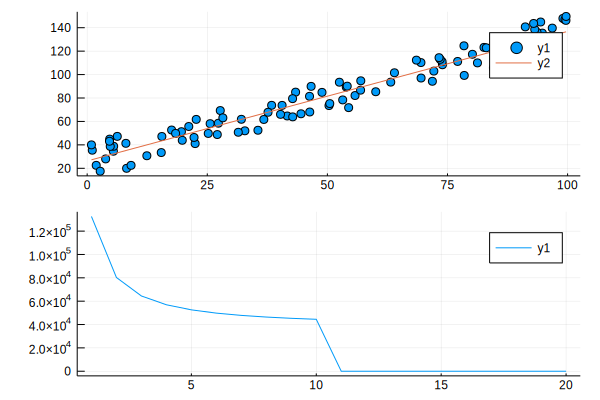

In [33]:
let
    addprocs(3)
    @everywhere using OnlineStats

    x, y = make_regression(npoints=100, noise=30, rng=MersenneTwister(1134))

    m = fit!(Moments(), x)
    μ, σ = mean(m), std(m)

    normalize(x, μ=0.0, σ=1.0) = [ones(size(x,1)) zscore(x, μ, σ)]
    x_norm = normalize(x, μ, σ)

    costs = SharedArray{Float64}(20)

    #o = @distributed merge for i = 1:20
    #    sl = StatLearn(2, NoPenalty(), rate=LearningRate(1))
    #    fit!(sl, (x_norm, y))
    #    y_hat = predict(sl, x_norm)
    #    costs[i] = sum(value(sl.loss, y, y_hat))
    #    println(costs[i])
    #    sl
    #end
    
    o = reduce(merge, pmap(partition(1:size(x_norm,1), 10)) do p
            sl = StatLearn(2, NoPenalty(), rate=LearningRate(1))
            x_chunk = x_norm[[p...],:]
            y_chunk = y[[p...]]
            for i = 1:10
                fit!(sl, (x_chunk, y_chunk))
                y_hat = predict(sl, x_norm)
                costs[i] += sum(value(sl.loss, y, y_hat))
            end
            sl
            end)

    rmprocs(workers())
    
    println(coef(o))

    p1 = scatter(x, y, subplot=1)
    plot!(p1, x, predict(o, x_norm))
    p2 = plot(costs)
    plot(p1, p2, layout=(2,1))
end